# Imports

In [10]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [11]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten
import time

from tensorflow.keras.layers import Lambda
#from keras.backend import slice

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Ploting
import matplotlib.pyplot as plt
%matplotlib inline

# Data Loading

In [12]:
!git clone https://github.com/shusunny/GAN-stock-entry.git

fatal: destination path 'GAN-stock-entry' already exists and is not an empty directory.


In [13]:
data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]
data_name = data_names[0]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path)

GAN-stock-entry/datasets/GOOG.csv


In [14]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,1089.420897,1100.046811,1079.321435,1090.083688,1090.083688,1.671534e+06
std,268.589405,272.693779,265.381490,269.099996,269.099996,7.686312e+05
min,667.849976,672.299988,663.059998,668.260010,668.260010,3.468000e+05
25%,835.755005,841.975006,831.254975,836.994995,836.994995,1.209400e+06
50%,1083.560059,1094.244995,1072.204956,1082.760010,1082.760010,1.466700e+06
75%,1229.390015,1241.369995,1219.445007,1230.540039,1230.540039,1.889050e+06
max,1824.520020,1847.199951,1822.650024,1827.989990,1827.989990,6.348100e+06


In [15]:
dataframe.shape

(1259, 7)

In [16]:
def add_Entry(dataframe):
  #Entry_window=5
  for i in range(0,dataframe.shape[0]):
    dataframe.loc[dataframe.index[i],'Entry'] = np.round((dataframe.iloc[i,3]+ (dataframe.iloc[i,2] -dataframe.iloc[i,3])*0.2),5)
  return dataframe

dataframe=add_Entry(dataframe)
dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Entry
0,2016-01-04,743.000000,744.059998,731.257996,741.840027,741.840027,3272800,733.81840
1,2016-01-05,746.450012,752.000000,738.640015,742.580017,742.580017,1950700,741.31201
2,2016-01-06,730.000000,747.179993,728.919983,743.619995,743.619995,1947000,732.57198
3,2016-01-07,730.309998,738.500000,719.059998,726.390015,726.390015,2963700,722.94800
4,2016-01-08,731.450012,733.229980,713.000000,714.469971,714.469971,2450900,717.04600


In [17]:
np.where(dataframe.to_numpy()==0)

(array([], dtype=int64), array([], dtype=int64))

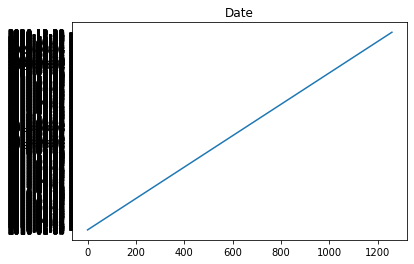

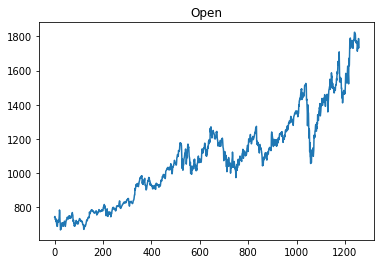

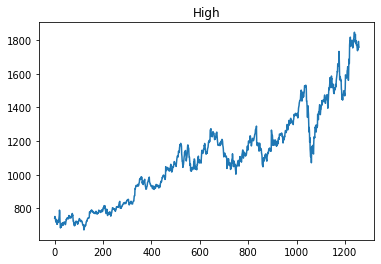

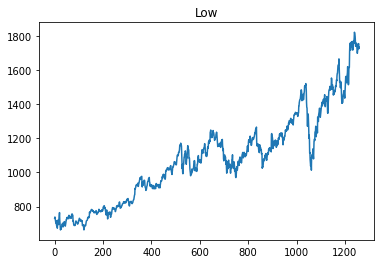

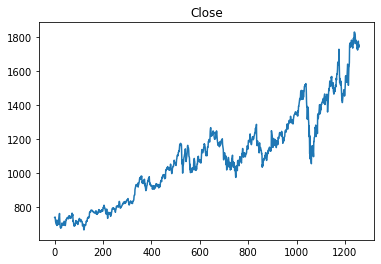

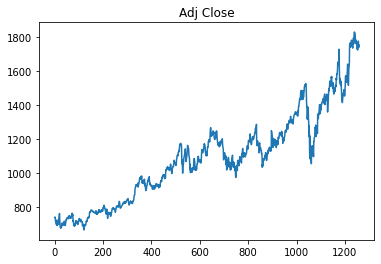

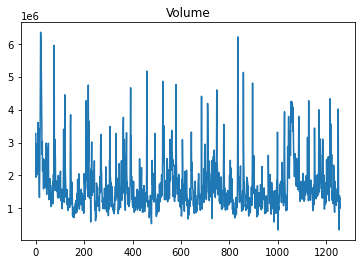

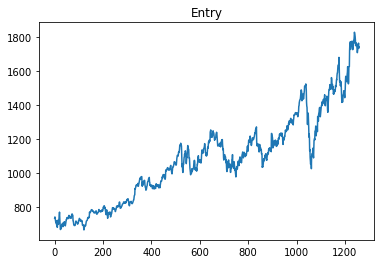

In [18]:
def plot_dataframe(dataframe):
  for column_name in dataframe.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(dataframe[column_name])

plot_dataframe(dataframe)

# Preprocessing

In [19]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    # shape : (n_batch, n_sequence, n_features)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:] #standarize along each feature
    targets = (targets - mean)/std # The Entry value is our target
    return samples, targets

In [20]:
# TimeseriesGenerator Check

data = np.array([[i, i**2,i**3,i**4] for i in range(11)])
#targets = np.array([[i**4] for i in range(11)])
targets = data

mean = data[:-1].mean(axis=0)[None,:]
std = data[:-1].std(axis=0)[None,:]

data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=1,
                               batch_size=2)
batch_0 = data_gen[0]
x, y = batch_0

print(np.array(x*std+mean,dtype = np.int))
print(y*std+mean)

[[[   0    0    0    0]
  [   1    1    1    1]
  [   2    4    8   16]
  [   3    9   27   81]
  [   4   16   64  256]
  [   5   25  125  625]
  [   6   36  216 1296]
  [   7   49  343 2401]
  [   8   64  512 4096]
  [   9   81  729 6561]]]
[[   10.   100.  1000. 10000.]]


In [21]:
n_sequence = 5
n_features = 7
n_batch = 32

def get_gen_train_test(dataframe):
  data = dataframe.drop(columns='Date').to_numpy()
  #targets = data[:,3, None] #add none to have same number of dimensions as data
  targets = data
  n_samples = data.shape[0]
  train_test_split=int(n_samples*0.9)

  data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
  data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

  return data_gen_train, data_gen_test

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

In [22]:
data_gen_train[0]

(array([[[-1.80364324, -1.7231663 , -1.84061267, ..., -0.95655828,
           1.48640278, -1.83224651],
         [-0.18107866, -0.19021384,  0.14610265, ..., -0.53509779,
          -0.51512734,  0.09372719],
         [ 0.38479393,  0.88172322,  1.10161843, ...,  1.89890793,
          -0.14305607,  1.07295344],
         [ 1.17820364,  1.10103046,  0.61383801, ...,  0.03077568,
           0.62555659,  0.69428666],
         [ 0.42172432, -0.06937353, -0.02094642, ..., -0.43802755,
          -1.45377595, -0.02872077]],
 
        [[ 1.19549483,  1.28877325,  1.37512337, ...,  1.34458267,
          -1.17815707,  1.36543419],
         [ 1.03734361,  0.85181254,  0.95794704, ...,  0.4478818 ,
          -1.1820914 ,  0.94311328],
         [-0.86199665, -0.60017302, -0.56317759, ..., -0.93898284,
           1.01326772, -0.57193128],
         [-0.04821271, -0.03985185, -0.49255382, ...,  0.50749553,
           0.29884669, -0.41492992],
         [-1.32262907, -1.50056092, -1.27733901, ..., -1.3609

In [23]:
data.shape

(11, 4)

In [24]:
# test on data
data = dataframe.drop(columns='Date').to_numpy()
targets = data

x_gen, y_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=1)[0]
print(x_gen)
print(y_gen)

x = data[None, :5,:]
mean = x.mean(axis=1)
std = x.std(axis=1)
x = (x - mean)/std
y = (data[5] - mean)/std
print('x:', x)
print('y:', y)

assert (x_gen == x).all()
assert (y_gen == y).all()

[[[ 0.9615339   0.16245112  0.55924707  0.69799102  0.69799102
    1.4178268   0.50040009]
  [ 1.45240481  1.37244886  1.37153545  0.76207352  0.76207352
   -1.06240397  1.37670208]
  [-0.88811819  0.63791534  0.3019813   0.85213473  0.85213473
   -1.06934509  0.35464386]
  [-0.84401139 -0.68485157 -0.78297272 -0.63996682 -0.63996682
    0.83796194 -0.77078337]
  [-0.68180913 -1.48796375 -1.4497911  -1.67223245 -1.67223245
   -0.12403968 -1.46096265]]]
[[-2.79326197 -3.67860772 -2.49073477 -1.53713276 -1.53713276 -0.79995462
  -2.68216834]]
x: [[[ 0.9615339   0.16245112  0.55924707  0.69799102  0.69799102
    1.4178268   0.50040009]
  [ 1.45240481  1.37244886  1.37153545  0.76207352  0.76207352
   -1.06240397  1.37670208]
  [-0.88811819  0.63791534  0.3019813   0.85213473  0.85213473
   -1.06934509  0.35464386]
  [-0.84401139 -0.68485157 -0.78297272 -0.63996682 -0.63996682
    0.83796194 -0.77078337]
  [-0.68180913 -1.48796375 -1.4497911  -1.67223245 -1.67223245
   -0.12403968 -1.46096

# Baseline 

In [25]:
# baseline: use previous days as estimation for the next
squared_error = 0
def mean_squared_error(X, lenght = 5):
  squared_error = 0
  for i in range(0, X.shape[0] - lenght):
    x = X[i:i+lenght]
    mean = x.mean()
    std = x.std()
    x = (x - mean)/std
    y = (X[i+lenght] - mean)/std
    squared_error += np.square(x[-1]-y)
  return squared_error/X.shape[0]

baseline_error = mean_squared_error(data[:,6])
baseline_error

4.317263898988826

In [26]:
data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=32)

# baseline: use previous day as estimation for the next
def mean_squared_error(dataset):
  mse=0
  for X_batch, y_batch in dataset:
    # X_batch.shape : (n_batch, n_sequence, n_features)
    #mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
    mse += np.mean(np.square(X_batch[:, -1, 6:7]-y_batch[:, 6:7]))
  mse /= len(dataset)
  return mse

baseline_error = mean_squared_error(data_gen)
baseline_error 

4.280646182369636

# Utilities

In [27]:
# Metrics not included in keras

# For some reason keras mape is different so it has to be customly defined.
# Paper definition isn't percentual, hence the difference. (x100)
def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

 

# GAN

## Perdidas

In [28]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse


## Generator

In [29]:
def make_generator_model():

  inputs = Input(shape=(n_sequence, n_features,))
  lstm_1 = LSTM(units=10, return_sequences = True, activation=None, kernel_initializer='random_normal')(inputs)
  batch_norm1=tf.keras.layers.BatchNormalization()(lstm_1)
  lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
  lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
  lstm_2 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
  batch_norm2=tf.keras.layers.BatchNormalization()(lstm_2)
  lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
  lstm_2_droput = Dropout(0.3)(lstm_2_LRelu)
  #lstm_3 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_2_droput)
  #batch_norm3=tf.keras.layers.BatchNormalization()(lstm_3)
  #lstm_3_LRelu = LeakyReLU(alpha=0.3)(batch_norm3) 
  #lstm_3_droput = Dropout(0.3)(lstm_3_LRelu)
  #lstm_4 = LSTM(units=100, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_3_droput)
  #batch_norm4=tf.keras.layers.BatchNormalization()(lstm_4)
  #lstm_4_LRelu = LeakyReLU(alpha=0.3)(batch_norm4) 
  #lstm_4_droput = Dropout(0.5)(lstm_4_LRelu)
  output_dense = Dense(n_features, activation=None)(lstm_2_droput)
  output = LeakyReLU(alpha=0.3)(output_dense) 

  #prediction = Lambda( lambda x: x[..., 3:4])(output)
  #slice_model = Model(inputs = inputs, outputs = prediction)
  #slice_model.compile(loss='mse', metrics = ['mse', 'mae', 'mape', rmse, ar])
  #slice_model.summary()

  model = Model(inputs = inputs, outputs = output)
  #model.compile(loss=generator_loss)
  model.compile(loss=None, metrics = [mse , mae, mape, rmse, ar])
  #model.compile(loss=None, metrics = [mse , mae, mape, rmse])
  model.summary()

  #return model, slice_model
  return model

  #history = model.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
   #                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
  


In [30]:
generator = make_generator_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 10)             720       
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 10)             0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40    

## Discriminator

In [31]:
def make_discriminator_model():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
  model.add(Dropout(0.3))
  model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(Dropout(0.3))
  model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
  model.add(Dropout(0.3))
  model.add(Dense(1 ,activation='sigmoid'))
  model.compile(loss=discriminator_loss)
  #history = model.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
   #                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
  return model


In [32]:
discriminator=make_discriminator_model()

In [33]:
learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

## Training

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
EPOCHS = 500

In [36]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

def train_step_def(sequences, sequences_end):
  # sequences is the real output

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_prediction = generator(sequences, training=True)

    sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

    real_output = discriminator(sequences_true, training=True)
    fake_output = discriminator(sequences_fake, training=True)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                            sequences_end, 
                                            fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
  generated_prediction = generator(sequences, training=False)

  sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
  sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

  real_output = discriminator(sequences_true, training=False)
  fake_output = discriminator(sequences_fake, training=False)

  gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
  disc_loss = discriminator_loss(real_output, fake_output)
  return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [37]:
#@tf.function
#def train_step(sequences, sequences_end):
#  return train_step_def(sequences, sequences_end)

#@tf.function
#def test_step(sequences, sequences_end):
#  return test_step_def(sequences, sequences_end)

In [38]:
def train(dataset, dataset_val, epochs):
  history = np.empty(shape = (8, epochs))
  history_val = np.empty(shape = (8, epochs))
  len_dataset = len(dataset)
  len_dataset_val = len(dataset_val)
  for epoch in range(epochs):
    start = time.time()

    cur_dis_loss = 0
    cur_gen_loss = 0
    cur_gen_mse_loss = 0
    for sequence_batch, sequence_end_batch in dataset:
      aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                  tf.cast(sequence_end_batch, tf.float32))
      cur_gen_loss += aux_cur_losses[0]/len_dataset
      cur_dis_loss += aux_cur_losses[1]/len_dataset
      cur_gen_mse_loss += aux_cur_losses[2]/len_dataset

    #cur_gen_loss = generator.evaluate(dataset,verbose=False)
    cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]
    #cur_dis_loss = discriminator.evaluate(dataset,verbose=False)

    history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics
    #history[:, epoch] = cur_gen_loss, *cur_gen_slice_metrics

    #cur_gen_loss_val = generator.evaluate(dataset_val,verbose=False)
    cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

    #cur_dis_loss_val = discriminator.evaluate(dataset_val,verbose=False)

    cur_gen_loss_val = 0
    cur_dis_loss_val = 0
    cur_gen_mse_loss_val = 0
    for sequence_batch, sequence_end_batch in dataset_val:
      aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                     tf.cast(sequence_end_batch, tf.float32))
      cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
      cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
      cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


    history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

    print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
           .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))
      
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  return history, history_val

In [39]:
#history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

## Visualization

In [60]:
metrics = ["Gen_loss","Dis_loss","Gen_mse_loss", 'MSE','MAE','RMSE','AR']

def plot_history(history, history_val):
  for i, metric_name in enumerate(metrics):  
    plt.figure()
    plt.title(metric_name)
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.plot(history[i], label='train')
    plt.plot(history_val[i], label='test')
    plt.legend()
  plt.show()

#plot_history(history, history_val)

In [59]:
def plot_frame(sequence, target, model):
  sequence, target = data_gen_test[0]
  y_pred = model.predict(sequence)[...,3]
  y_true = target[...,3]

  plt.figure()
  plt.title("Entry price errors")
  plt.xlabel('Test samples')
  plt.ylabel("Errors")
  plt.plot(y_true, label="true")
  plt.plot(y_pred, label="prediction")
  plt.legend()
  plt.show()

#plot_frame(*data_gen_test[0], generator)

In [53]:
def get_best_results(history):
  # get best mse
  min_index = np.argmin(history[3, :])

  return history[:, min_index]

#get_best_results(history_val)

# Test on all datasets

In [54]:
results = np.zeros((5,8))

### Google Stock

GAN-stock-entry/datasets/GOOG.csv
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_16 (Batc (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 10)                840       
_________________________________________________________________
batch_normalization_17 (B

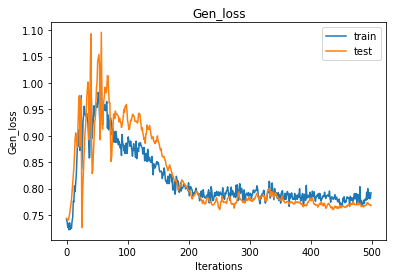

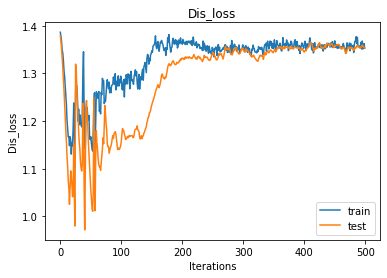

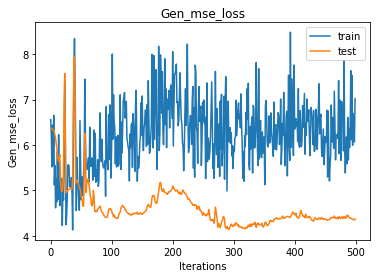

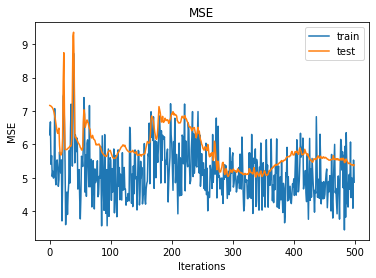

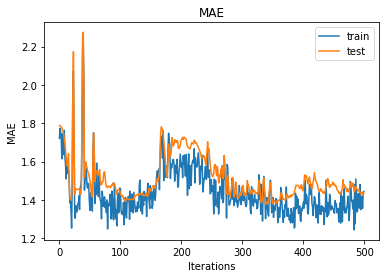

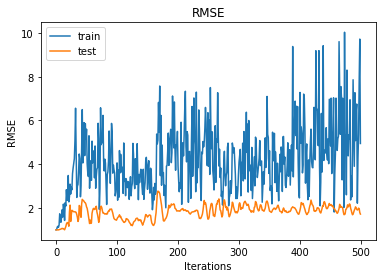

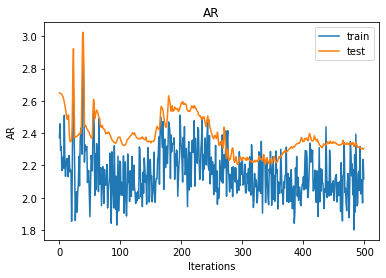

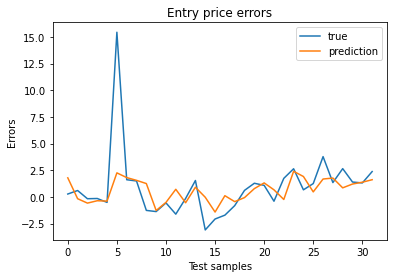

[MSE Baseline] train: 3.435596425737223  test: 2.812859025419686
['Gen_loss', 'Dis_loss', 'Gen_mse_loss', 'MSE', 'MAE', 'RMSE', 'AR'] =
 [0.79324788 1.34134114 4.22495747 5.01804543 1.37681258 1.90043664
 2.21108913 0.62069237]


In [61]:
i = 0 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Apple Stock

GAN-stock-entry/datasets/AAPL.csv
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_5 (Ba

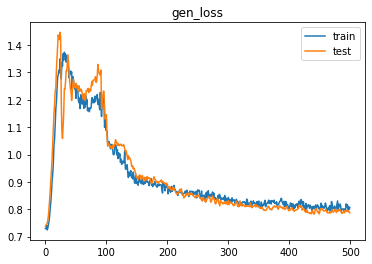

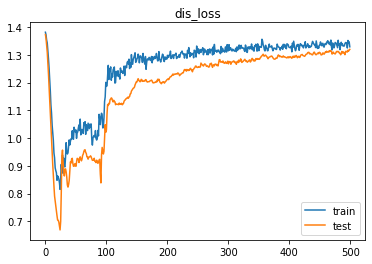

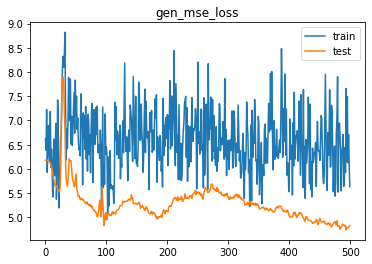

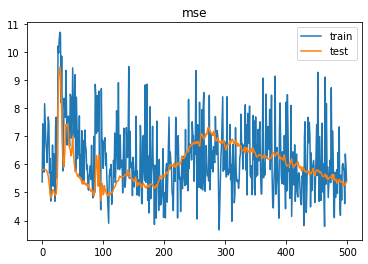

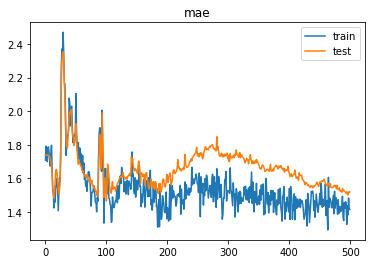

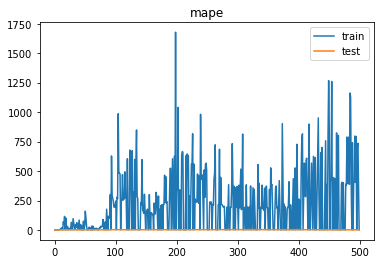

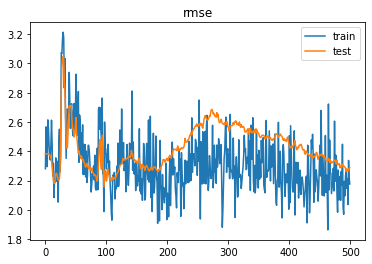

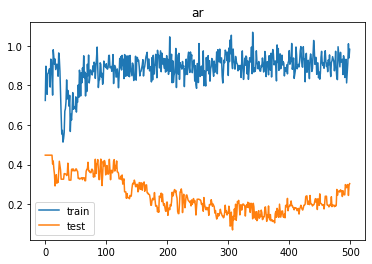

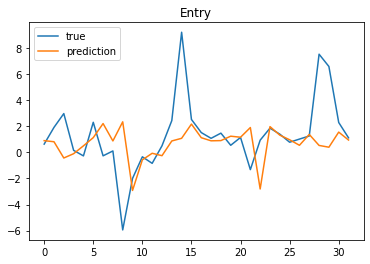

[MSE Baseline] train: 4.639290409336222  test: 3.883730321570804
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [1.23107028 0.95197463 4.8273387  4.71507168 1.48634005 2.49784398
 2.15679288 0.39225218]


In [46]:
i = 1 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Amazon Stock

GAN-stock-entry/datasets/AMZN.csv
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_7 (Ba

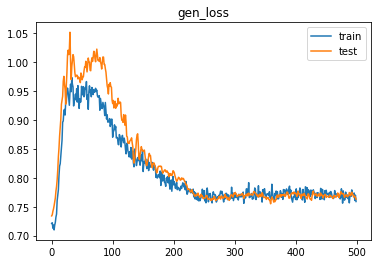

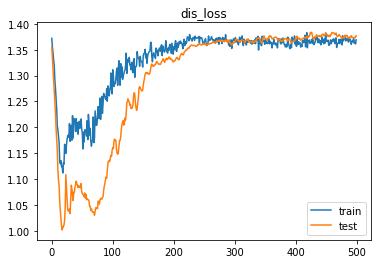

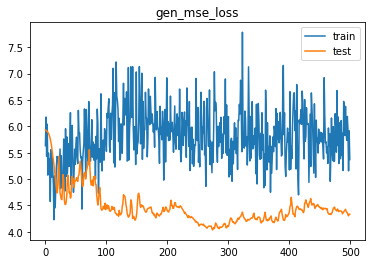

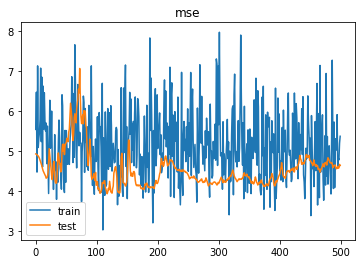

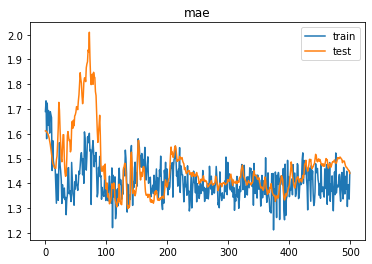

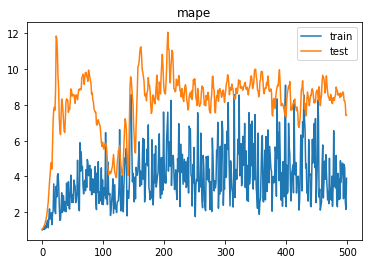

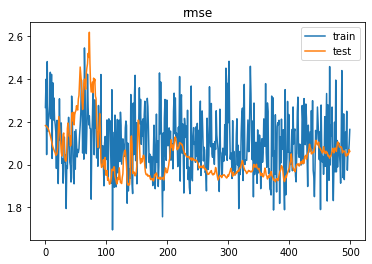

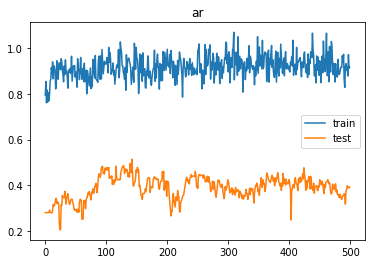

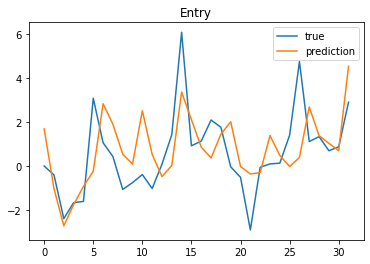

[MSE Baseline] train: 3.590714473453316  test: 3.8536905955453555
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [0.89593065 1.21287692 4.31745911 3.9328084  1.30523133 5.23009205
 1.90921521 0.43118915]


In [47]:
i = 2 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]
data_name = data_names[i]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"
print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Facebook Stock

GAN-stock-entry/datasets/FB.csv
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                840       
_________________________________________________________________
batch_normalization_9 (Batc

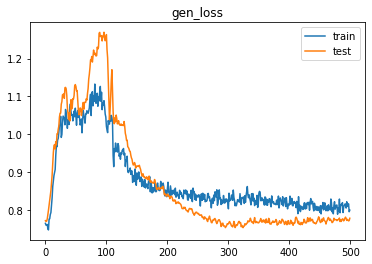

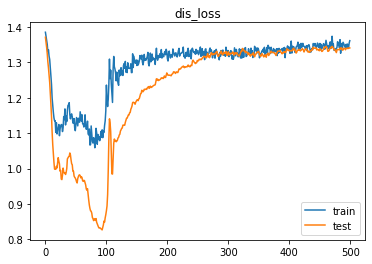

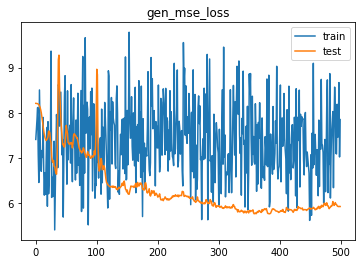

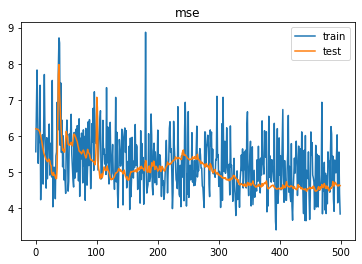

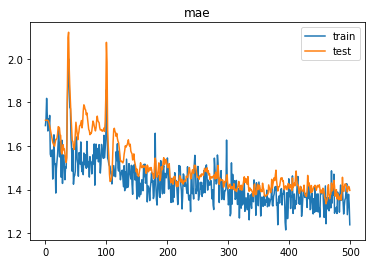

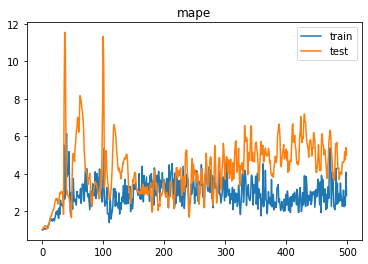

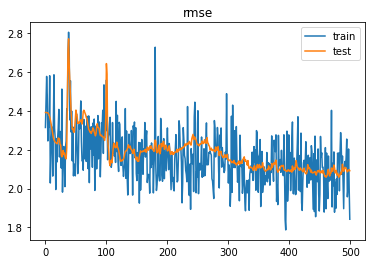

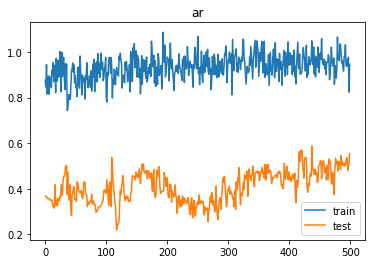

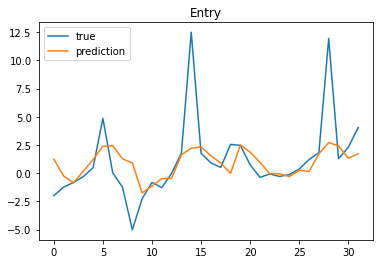

[MSE Baseline] train: 5.208162167146295  test: 8.240952977742106
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [0.76522553 1.33951354 5.84307575 4.46550274 1.39659822 5.35574198
 2.06935716 0.46285057]


In [48]:
i = 3 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"

print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

### Tesla Stock

GAN-stock-entry/datasets/TSLA.csv
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 10)             720       
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 10)             40        
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 5, 10)             0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                840       
_________________________________________________________________
batch_normalization_11 (B

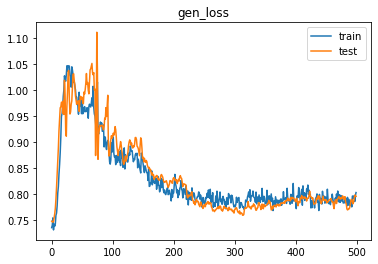

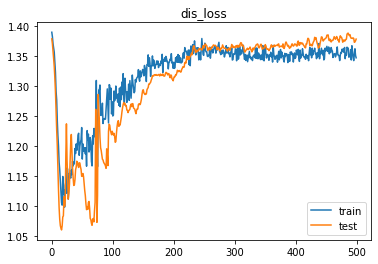

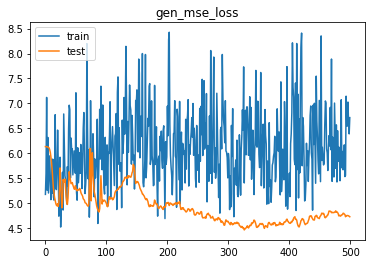

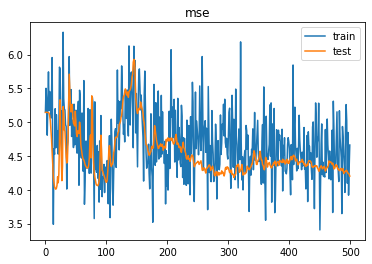

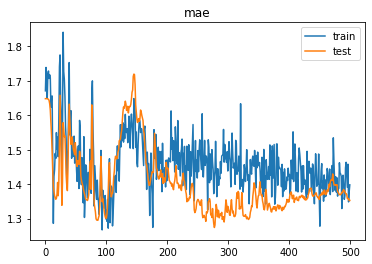

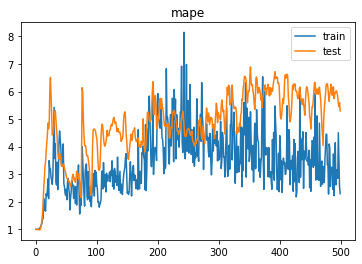

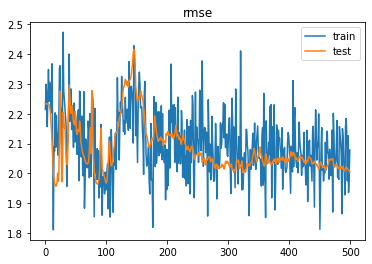

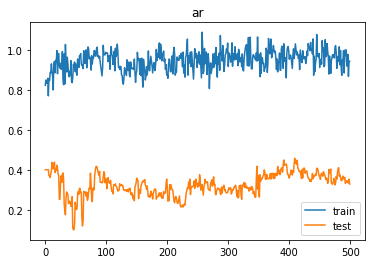

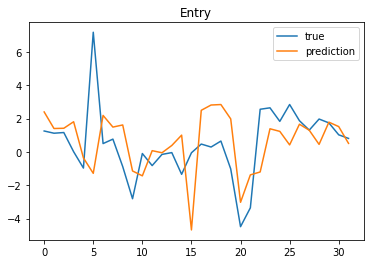

[MSE Baseline] train: 3.4669311359671044  test: 2.5058397803284445
['gen_loss', 'dis_loss', 'gen_mse_loss', 'mse', 'mae', 'mape', 'rmse', 'ar'] =
 [0.97600973 1.06730986 4.99260759 4.00813293 1.35607588 3.84020758
 1.9569602  0.40113711]


In [49]:
i = 4 #data_names = ["GOOG","AAPL","AMZN","FB","TSLA"]

data_name = data_names[i]
data_path="GAN-stock-entry/datasets/"+data_name+".csv"

print(data_path)
dataframe = pd.read_csv(data_path).dropna()

dataframe = add_Entry(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

generator = make_generator_model()
discriminator=make_discriminator_model()

learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

checkpoint_dir = './training_checkpoints'+data_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

plot_history(history, history_val)
plot_frame(*data_gen_test[0], generator)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))

results[i] = get_best_results(history_val)
print(metrics,"=\n",results[i])

## Results

In [50]:
df = pd.DataFrame(data = results, index = data_names, columns = metrics)
df.loc['mean'] = results.mean(axis=0)
df

,gen_loss,dis_loss,gen_mse_loss,mse,mae,mape,rmse,ar
GOOG,0.901191,1.243969,4.582644,5.515080,1.441899,1.843042,2.324430,0.608160
AAPL,1.231070,0.951975,4.827339,4.715072,1.486340,2.497844,2.156793,0.392252
AMZN,0.895931,1.212877,4.317459,3.932808,1.305231,5.230092,1.909215,0.431189
FB,0.765226,1.339514,5.843076,4.465503,1.396598,5.355742,2.069357,0.462851
TSLA,0.976010,1.067310,4.992608,4.008133,1.356076,3.840208,1.956960,0.401137
mean,0.953885,1.163129,4.912625,4.527319,1.397229,3.753385,2.083351,0.459118
